In [1]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torch

# Global Variables

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_folder = 'dataset/'

### Loading Training Data

In [3]:
tr_fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images, tr_targets = tr_fmnist.data, tr_fmnist.targets

C:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Loading Test Data

In [4]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images, val_targets = val_fmnist.data, val_fmnist.targets

# Functions And Classes

In [5]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255
        x = x.view(-1, 28 * 28)
        self.x, self.y = x, y
    
    def __getitem__(self, ix):
        return self.x[ix].to(device), self.y[ix].to(device)
    
    def __len__(self):
        return self.x.shape[0]

In [6]:
def get_model(hidden_layer_numbers, learning_rate):
    if hidden_layer_numbers == 0:
        model = nn.Sequential(
                                nn.Linear(28 * 28, 10)
                            ).to(device)
    elif hidden_layer_numbers == 1:
        model = nn.Sequential(
                                nn.Linear(28 * 28, 1000),
                                nn.ReLU(),
                                nn.Linear(1000, 10)
                            ).to(device)
    elif hidden_layer_numbers == 2:
        model = nn.Sequential(
                                nn.Linear(28 * 28, 1000),
                                nn.ReLU(),
                                nn.Linear(1000, 1000),
                                nn.ReLU(),
                                nn.Linear(1000, 10)
                            ).to(device)
    else:
        print("No more than 2 hidden layers are supported in this practice")
        exit()
        
    loss_function = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    return model, optimizer, loss_function

In [7]:
def train_batch(x, y, model, optimizer, loss_function):
    model.train()
    prediction = model(x)
    batch_loss = loss_function(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [8]:
def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [9]:
def get_data(batch_size):
    train_data = FMNISTDataset(tr_images, tr_targets)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    val_data = FMNISTDataset(val_images, val_targets)
    val_dataloader = DataLoader(val_data, batch_size=val_images.shape[0], shuffle=False)
    
    return train_dataloader, val_dataloader

In [10]:
@torch.no_grad()
def val_loss(x, y, model, loss_function):
    model.eval()
    prediction = model(x)
    val_loss = loss_function(prediction, y)
    return val_loss.item()

# Training model with 0 hidden layers

In [11]:
train_dataloader, val_datalader = get_data(batch_size=32)
model, optimizer, loss_function = get_model(hidden_layer_numbers=0, learning_rate=1e-2)

In [12]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
    print(f"Current epoch: {epoch}")
    
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for batch in train_dataloader:
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_function)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.mean(train_epoch_losses)
    
    for batch in train_dataloader:
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for batch in val_datalader:
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_loss = val_loss(x, y, model, loss_function)
        
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

Current epoch: 0
Current epoch: 1
Current epoch: 2
Current epoch: 3
Current epoch: 4
Current epoch: 5
Current epoch: 6
Current epoch: 7
Current epoch: 8
Current epoch: 9
Current epoch: 10
Current epoch: 11
Current epoch: 12
Current epoch: 13
Current epoch: 14
Current epoch: 15
Current epoch: 16
Current epoch: 17
Current epoch: 18
Current epoch: 19
Current epoch: 20
Current epoch: 21
Current epoch: 22
Current epoch: 23
Current epoch: 24
Current epoch: 25
Current epoch: 26
Current epoch: 27
Current epoch: 28
Current epoch: 29


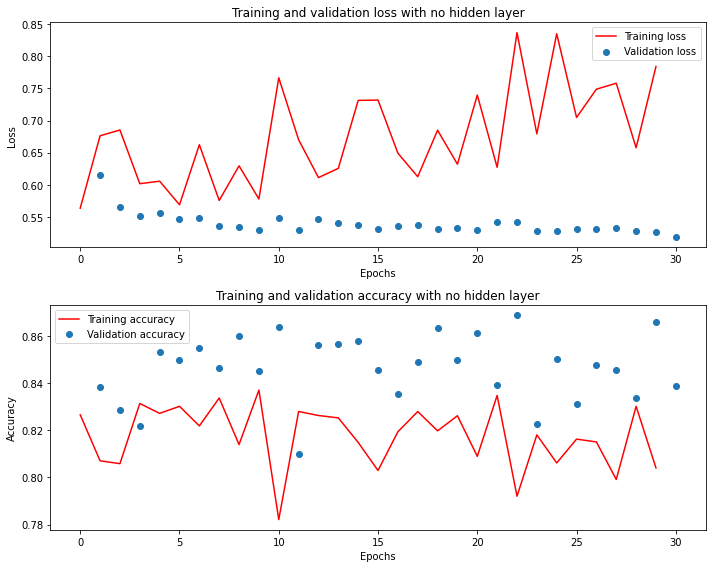

In [13]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

epochs = [i for i in range(1, 31)]

# Add data to ax0
ax0.scatter(x=epochs,
            y=train_losses)
ax0.plot(val_losses, color='red')

# Customize ax0
ax0.set(title= "Training and validation loss with no hidden layer",
        ylabel= "Loss",
        xlabel= "Epochs")

# Add legend to ax0
ax0.legend(['Training loss', 'Validation loss'])

# Add data to ax1
ax1.scatter(x=epochs,
            y=train_accuracies)
ax1.plot(val_accuracies, color='red')

# Customize ax1
ax1.set(title= "Training and validation accuracy with no hidden layer",
        ylabel= "Accuracy",
        xlabel= "Epochs")

# Add legend to ax1
ax1.legend(['Training accuracy', 'Validation accuracy'])

plt.tight_layout();

# Training model with 1 hidden layers

In [14]:
train_dataloader, val_datalader = get_data(batch_size=32)
model, optimizer, loss_function = get_model(hidden_layer_numbers=1, learning_rate=1e-2)

In [15]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
    print(f"Current epoch: {epoch}")
    
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for batch in train_dataloader:
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_function)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.mean(train_epoch_losses)
    
    for batch in train_dataloader:
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for batch in val_datalader:
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_loss = val_loss(x, y, model, loss_function)
        
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

Current epoch: 0
Current epoch: 1
Current epoch: 2
Current epoch: 3
Current epoch: 4
Current epoch: 5
Current epoch: 6
Current epoch: 7
Current epoch: 8
Current epoch: 9
Current epoch: 10
Current epoch: 11
Current epoch: 12
Current epoch: 13
Current epoch: 14
Current epoch: 15
Current epoch: 16
Current epoch: 17
Current epoch: 18
Current epoch: 19
Current epoch: 20
Current epoch: 21
Current epoch: 22
Current epoch: 23
Current epoch: 24
Current epoch: 25
Current epoch: 26
Current epoch: 27
Current epoch: 28
Current epoch: 29


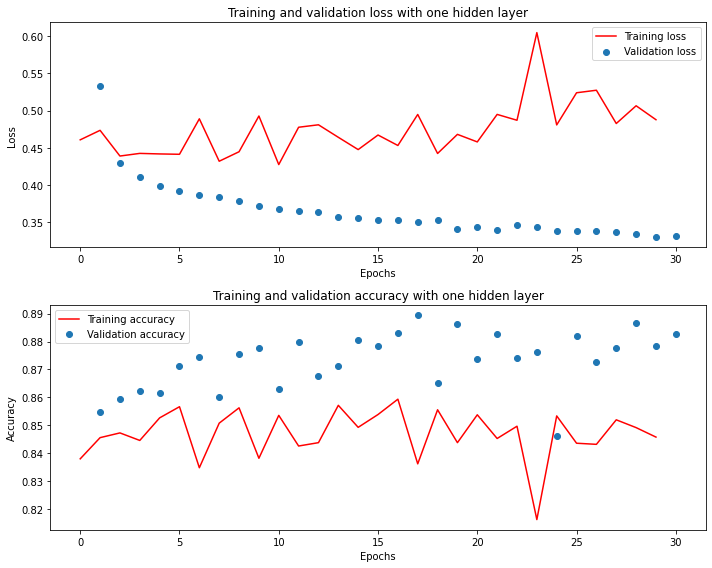

In [16]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

epochs = [i for i in range(1, 31)]

# Add data to ax0
ax0.scatter(x=epochs,
            y=train_losses)
ax0.plot(val_losses, color='red')

# Customize ax0
ax0.set(title= "Training and validation loss with one hidden layer",
        ylabel= "Loss",
        xlabel= "Epochs")

# Add legend to ax0
ax0.legend(['Training loss', 'Validation loss'])

# Add data to ax1
ax1.scatter(x=epochs,
            y=train_accuracies)
ax1.plot(val_accuracies, color='red')

# Customize ax1
ax1.set(title= "Training and validation accuracy with one hidden layer",
        ylabel= "Accuracy",
        xlabel= "Epochs")

# Add legend to ax1
ax1.legend(['Training accuracy', 'Validation accuracy'])

plt.tight_layout();

# Training model with 2 hidden layers

In [17]:
train_dataloader, val_datalader = get_data(batch_size=32)
model, optimizer, loss_function = get_model(hidden_layer_numbers=2, learning_rate=1e-2)

In [18]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
    print(f"Current epoch: {epoch}")
    
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for batch in train_dataloader:
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_function)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.mean(train_epoch_losses)
    
    for batch in train_dataloader:
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for batch in val_datalader:
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_loss = val_loss(x, y, model, loss_function)
        
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

Current epoch: 0
Current epoch: 1
Current epoch: 2
Current epoch: 3
Current epoch: 4
Current epoch: 5
Current epoch: 6
Current epoch: 7
Current epoch: 8
Current epoch: 9
Current epoch: 10
Current epoch: 11
Current epoch: 12
Current epoch: 13
Current epoch: 14
Current epoch: 15
Current epoch: 16
Current epoch: 17
Current epoch: 18
Current epoch: 19
Current epoch: 20
Current epoch: 21
Current epoch: 22
Current epoch: 23
Current epoch: 24
Current epoch: 25
Current epoch: 26
Current epoch: 27
Current epoch: 28
Current epoch: 29


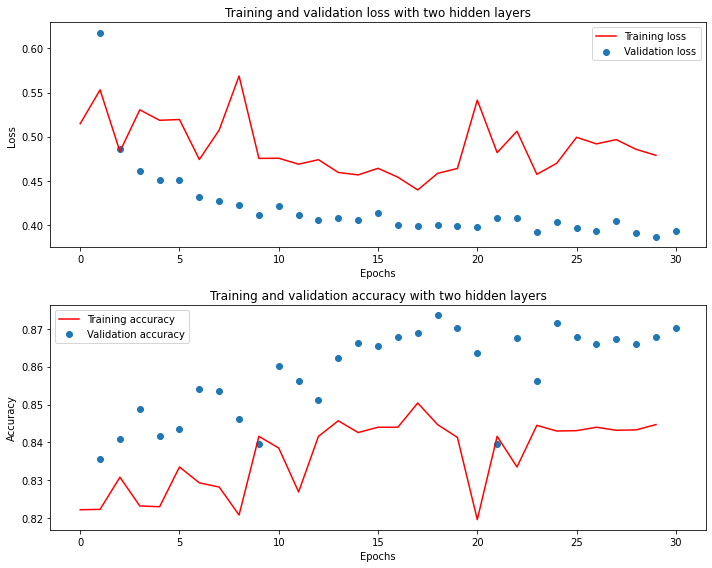

In [19]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

epochs = [i for i in range(1, 31)]

# Add data to ax0
ax0.scatter(x=epochs,
            y=train_losses)
ax0.plot(val_losses, color='red')

# Customize ax0
ax0.set(title= "Training and validation loss with two hidden layers",
        ylabel= "Loss",
        xlabel= "Epochs")

# Add legend to ax0
ax0.legend(['Training loss', 'Validation loss'])

# Add data to ax1
ax1.scatter(x=epochs,
            y=train_accuracies)
ax1.plot(val_accuracies, color='red')

# Customize ax1
ax1.set(title= "Training and validation accuracy with two hidden layers",
        ylabel= "Accuracy",
        xlabel= "Epochs")

# Add legend to ax1
ax1.legend(['Training accuracy', 'Validation accuracy'])

plt.tight_layout();